# QOSF Mentorship Program Screening Tasks

## Task 3 ZNE

Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of interest. In this task, you will build a simple ZNE function from scratch:

1. Build a simple noise model with depolarizing noise 
2. Create different circuits to test your noise models and choose the observable to measure 
3. Apply the unitary folding method. 
4. Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
5. Compare mitigated and unmitigated results 
6. Bonus: Run your ZNE function in real quantum hardware through the [IBM Quantum Service](https://www.ibm.com/quantum)

Check the [Mitiq documentation](https://mitiq.readthedocs.io/en/stable/guide/zne-5-theory.html) for references. You are not allowed to use the functions from Mitiq or any other frameworks where ZNE is already implemented. 


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error
)
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Step 1: Build a simple noise model with depolarizing noise
def create_noise_model(depolarizing_error_prob):
    noise_model = NoiseModel()
    # Depolarizing error for single-qubit gates
    depolarizing_error_1q = depolarizing_error(depolarizing_error_prob, 1)
    # Depolarizing error for two-qubit gates (cx)
    depolarizing_error_2q = depolarizing_error(depolarizing_error_prob * 2, 2)
    
    noise_model.add_all_qubit_quantum_error(depolarizing_error_1q, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error_2q, ['cx'])
    
    return noise_model

# Step 2: Create a simple quantum circuit to test the noise model
def create_bell_state_circuit():
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

# Step 3: Apply the unitary folding method - here we'll define a function to fold a circuit
def fold_circuit(circuit, fold_factor):
    folded_circuit = circuit.copy()
    for _ in range(fold_factor):
        for gate in reversed(circuit.data):
            if gate.operation.name != 'measure':
                folded_circuit.data.append(gate)
        for gate in circuit.data:
            if gate.operation.name != 'measure':
                folded_circuit.data.append(gate)
    for n in range(circuit.num_qubits):
        folded_circuit.measure(n,n)
    return folded_circuit

# Test the noise model and circuit creation
def execute_circuits_with_noise(circuit, backend, noise_model):
    # Execute the circuit on the backend with the noise model
    new_circuit = transpile(circuit, backend)
    job = backend.run(new_circuit,noise_model=noise_model, shots=2048)
    result = job.result().get_counts()
    return result

def execute_circuits(circuit, backend):
    # Execute the circuit on the backend in ideal case
    new_circuit = transpile(circuit, backend)
    job = backend.run(new_circuit, shots=2048)
    result = job.result().get_counts()
    return result

def probabilities_measure(results):
    combined_dict = {}
    # Iterate through each dictionary in the list
    for d in results:
        for key, value in d.items():
            # If the key is already in the combined_dict, append the value to its tuple
            if key in combined_dict:
                combined_dict[key] += [value,]
            # Otherwise, create a new tuple with the value
            else:
                combined_dict[key] = [value,]

    probabilities = {key: list(value / 2048 for value in values) for key, values in combined_dict.items()}
    return probabilities

# Apply the extrapolation method to get the zero-noise limit
def extrapolate_zero_noise(fold_factors, results, extrapolation_method):
    # Define extrapolation function based on the chosen method
    if extrapolation_method == 'linear':
        def extrapolation_func(x, a, b):
            return a * x + b
    elif extrapolation_method == 'polynomial':
        def extrapolation_func(x, a, b, c):
            return a * x**2 + b * x + c
    elif extrapolation_method == 'exponential':
        def extrapolation_func(x, a, b):
            return a * np.exp(b * x)
    zero_noise_limits = {}
    x = fold_factors
    for key, value in results.items():
        y = value
        # Fit the data to the extrapolation function
        popt, _ = curve_fit(extrapolation_func, x, y)

        # Extrapolate to zero noise
        zero_noise_limit = extrapolation_func(0, *popt)
        zero_noise_limits[key] = zero_noise_limit
    return zero_noise_limits

In [3]:
def run_zne(qc, backend, noise_model, fold_factors, extrapolation_method='linear'):
    noisy_results = []
    for fold_factor in fold_factors:
        folded_circuit = fold_circuit(qc,fold_factor)
        noisy_result = execute_circuits_with_noise(folded_circuit, backend, noise_model)
        noisy_results.append(noisy_result)
    prob_noisy = probabilities_measure(noisy_results)
    zero_noise_limits = extrapolate_zero_noise(fold_factors, prob_noisy, extrapolation_method)
    for n in range(qc.num_qubits):
        qc.measure(n,n)
    ideal_result =[execute_circuits(qc,backend)]
    prob_ideal = probabilities_measure(ideal_result)
    
    return {'ideal': prob_ideal, 'unmitigated': prob_noisy, 'mitigated': zero_noise_limits}

In [10]:
# Test the noise model and circuit creation
noise_model = create_noise_model(0.3)  # Depolarizing error probability
qc = create_bell_state_circuit()
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-skku/kyunghee-univers/kh-graduate',
    token='a31caad39519f6f302e0c199c269fdf896dfd354849c28e42091c464a09318abb156bb93cb5e1f73ef095093072d01ade10d5136a7aeebf5c00a3d769a1fccac'
)
backend = service.backend("ibmq_qasm_simulator")
# Example usage with linear extrapolation
fold_factors = [0,1,3,5, 7, 9]  # Original and 3 levels of folding
results = run_zne(qc, backend, noise_model, fold_factors, 'exponential')

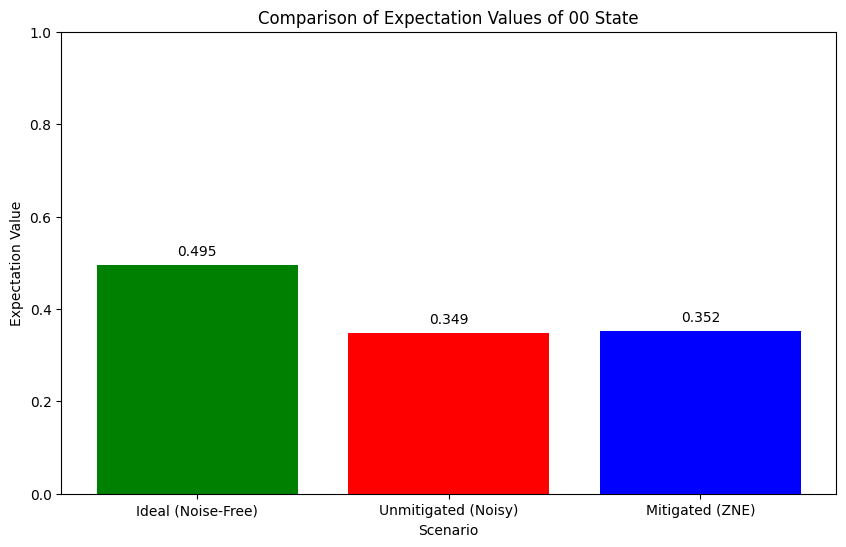

In [13]:
# Compare mitigated and unmitigated result with the ideal result

expectation_values_00 = {
    'Ideal (Noise-Free)': results['ideal']['00'][0],
    'Unmitigated (Noisy)': results['unmitigated']['00'][0],
    'Mitigated (ZNE)': results['mitigated']['00']
}

# Names of the scenarios for plotting
scenarios = expectation_values_00.keys()

# Expectation values for plotting
values = expectation_values_00.values()

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(scenarios, values, color=['green', 'red', 'blue'])

# Adding title and labels
plt.title('Comparison of Expectation Values of 00 State')
plt.xlabel('Scenario')
plt.ylabel('Expectation Value')

# Displaying numerical values on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.3f}", ha = 'center')

# Show plot
plt.ylim(0, 1)  # Assuming expectation values range from 0 to 1
plt.show()

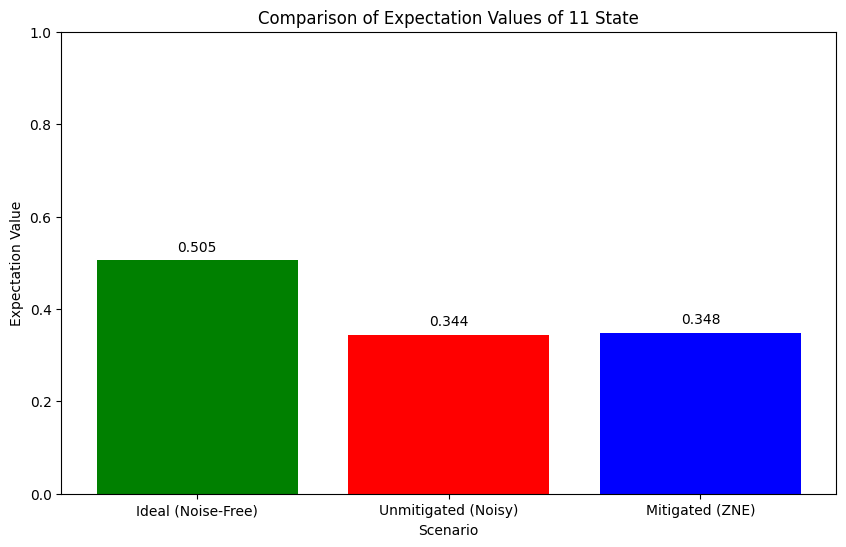

In [15]:
# Compare mitigated and unmitigated result with the ideal result

expectation_values_11 = {
    'Ideal (Noise-Free)': results['ideal']['11'][0],
    'Unmitigated (Noisy)': results['unmitigated']['11'][0],
    'Mitigated (ZNE)': results['mitigated']['11']
}

# Names of the scenarios for plotting
scenarios = expectation_values_11.keys()

# Expectation values for plotting
values = expectation_values_11.values()

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(scenarios, values, color=['green', 'red', 'blue'])

# Adding title and labels
plt.title('Comparison of Expectation Values of 11 State')
plt.xlabel('Scenario')
plt.ylabel('Expectation Value')

# Displaying numerical values on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.3f}", ha = 'center')

# Show plot
plt.ylim(0, 1)  # Assuming expectation values range from 0 to 1
plt.show()